# Predicting vaccination rates in the US


## Models used:

- `Regularised regression`
- `Random Forest regression`
- `Gradient Boosted Decision Trees`
- `SVM`?
- `NN`?


### Normalisation:

- `Regularised regression`



In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from numpy.random import seed
seed(1)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

tf.random.set_seed(1234)

2.6.0


In [29]:
base = os.path.split(os.getcwd())[0]
dd = base + '/data/'

In [30]:
df_all = pd.read_csv(dd + 'data_after_imputation.csv')

In [31]:
df_all.columns

Index(['fips', 'state', 'county', 'state_abb', 'pop_full_12plus_per',
       'pop_full_18plus_per', 'pop_full_65plus_per', 'cases_prop',
       'death_prop', 'hesitant_unsure', 'SVI', 'SVI_cat', 'CVAC', 'CVAC_cat',
       'Hispanic (%)', 'non-Hispanic American Indian/Alaska Native (%)',
       'non-Hispanic Asian (%)', 'non-Hispanic Black (%)',
       'non-Hispanic Native Hawaiian/Pacific Islander (%)',
       'non-Hispanic White (%)', 'noHealthInsurance', 'noHighSchool',
       'Poverty', 'logPopDensity', 'Urban_rural_code', 'PrematureDeath',
       'Smoking', 'anycondition_prevalence', 'per_dem', 'per_voted', 'Testing',
       'Traffic', 'DaytimePopDensity', 'ToxPi Score'],
      dtype='object')

In [32]:
df_all.isnull().sum()[df_all.isnull().sum() > 1]

pop_full_12plus_per     55
pop_full_18plus_per    266
pop_full_65plus_per      8
dtype: int64

### Drop `NaN` from target:

In [33]:
df = df_all[df_all['pop_full_12plus_per'].notna()]

In [34]:
print(df.columns)
print(len(df.columns))

Index(['fips', 'state', 'county', 'state_abb', 'pop_full_12plus_per',
       'pop_full_18plus_per', 'pop_full_65plus_per', 'cases_prop',
       'death_prop', 'hesitant_unsure', 'SVI', 'SVI_cat', 'CVAC', 'CVAC_cat',
       'Hispanic (%)', 'non-Hispanic American Indian/Alaska Native (%)',
       'non-Hispanic Asian (%)', 'non-Hispanic Black (%)',
       'non-Hispanic Native Hawaiian/Pacific Islander (%)',
       'non-Hispanic White (%)', 'noHealthInsurance', 'noHighSchool',
       'Poverty', 'logPopDensity', 'Urban_rural_code', 'PrematureDeath',
       'Smoking', 'anycondition_prevalence', 'per_dem', 'per_voted', 'Testing',
       'Traffic', 'DaytimePopDensity', 'ToxPi Score'],
      dtype='object')
34


In [35]:
y = df['pop_full_12plus_per']
X = df.drop(columns = ['state_abb', 
                       'pop_full_12plus_per',
                       'pop_full_18plus_per', 
                       'pop_full_65plus_per',
                       'SVI_cat', 
                       'CVAC_cat', 
                       'Testing', # not static
                       'ToxPi Score', # not static
                       'logPopDensity', # have DaytimePopDensity
                       'PrematureDeath', # have death_prop
                       ])

## Split data into `train`, `val` and `test` samples.

- predict `pop_full_12plus_per` for now.

#### `y_test` - leave until final model has been picked.

In [36]:
X_train_val_fips, X_test_fips, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [37]:
print('test data shape:', y_test.shape)

test data shape: (611,)


In [38]:
X_train_fips, X_val_fips, y_train, y_val = train_test_split(X_train_val_fips, y_train_val,
                                                           test_size = 0.2, random_state = 42)

In [39]:
print('train data shape:', y_train.shape)
print('val data shape:', y_val.shape)

train data shape: (1953,)
val data shape: (489,)


#### Drop `fips` for modelling

In [40]:
X_test = X_test_fips.drop(columns = ['fips','state', 'county'])
X_train = X_train_fips.drop(columns = ['fips','state', 'county'])
X_val = X_val_fips.drop(columns = ['fips','state', 'county'])

In [41]:
X_train.shape

(1953, 21)

In [42]:
print(X_train.columns)
print(len(X_train.columns))

Index(['cases_prop', 'death_prop', 'hesitant_unsure', 'SVI', 'CVAC',
       'Hispanic (%)', 'non-Hispanic American Indian/Alaska Native (%)',
       'non-Hispanic Asian (%)', 'non-Hispanic Black (%)',
       'non-Hispanic Native Hawaiian/Pacific Islander (%)',
       'non-Hispanic White (%)', 'noHealthInsurance', 'noHighSchool',
       'Poverty', 'Urban_rural_code', 'Smoking', 'anycondition_prevalence',
       'per_dem', 'per_voted', 'Traffic', 'DaytimePopDensity'],
      dtype='object')
21


In [43]:
normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)


In [44]:
normalizer.adapt(np.array(X_train))

In [45]:
model1 = tf.keras.Sequential([
    normalizer,
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

In [46]:
def build_and_compile_model(model):
  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))
  return model

In [47]:
dnn_model1 = build_and_compile_model(model1)
dnn_model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 21)                43        
_________________________________________________________________
dense_8 (Dense)              (None, 256)               5632      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)               

In [48]:
%%time
history = dnn_model1.fit(
    X_train,
    y_train,
    validation_data = (X_val, y_val),
    verbose=0, epochs=80)

Wall time: 7.81 s


In [49]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Vaccination%]')
  plt.legend()
  plt.grid(True)

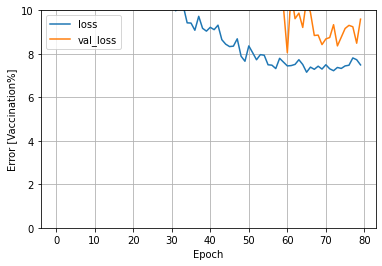

In [50]:
plot_loss(history)

In [51]:
model2 = tf.keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

In [52]:
dnn_model2 = build_and_compile_model(model2)
dnn_model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 21)                43        
_________________________________________________________________
dense_13 (Dense)             (None, 64)                1408      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 5,676
Trainable params: 5,633
Non-trainable params: 43
_________________________________________________________________


Wall time: 4.71 s


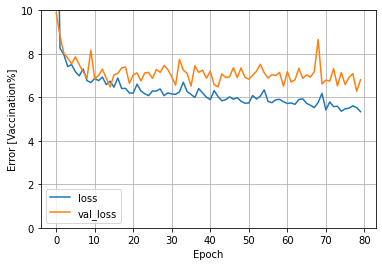

In [53]:
%%time
history = dnn_model2.fit(
    X_train,
    y_train,
    validation_data = (X_val, y_val),
    verbose=0, epochs=80)
plot_loss(history)

In [54]:
dnn_model2.evaluate(X_val, y_val, verbose=0)

6.81100606918335

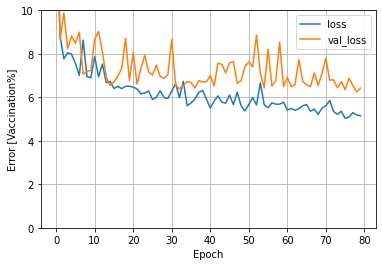

In [55]:
model3 = keras.Sequential([
    normalizer,
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

dnn_model3 = build_and_compile_model(model3)

history = dnn_model3.fit(
    X_train,
    y_train,
    validation_data = (X_val, y_val),
    verbose=0, epochs=80)
plot_loss(history)

In [56]:
print(dnn_model3.evaluate(X_val, y_val, verbose=0))

6.426344394683838


7.878239154815674


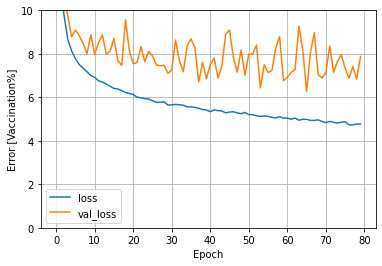

In [57]:
model4 = keras.Sequential([
    normalizer,
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
model4.compile(optimizer='rmsprop',
              loss='mean_absolute_error')

history = model4.fit(
    X_train,
    y_train,
    validation_data = (X_val, y_val),
    verbose=0, epochs=80)
plot_loss(history)
print(model4.evaluate(X_val, y_val, verbose=0))

-------
## Individual models: